In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal, mannwhitneyu, sem, wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import sem
import scikit_posthocs as sp

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Specify the path to your Helvetica Neue Regular font file
helvetica_neue_path = "/home/mstier/.local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object using the font path
prop_neue = fm.FontProperties(fname=helvetica_neue_path)

# Get the font name from FontProperties
helvetica_neue_name = prop_neue.get_name()

# Define custom context for font sizes and line thickness using Seaborn
custom_context = {
    'font.size': 7,                    # General font size for the plot
    'axes.labelsize': 7,               # Font size for axis labels
    'axes.titlesize': 7,               # Font size for titles
    'legend.fontsize': 7,              # Font size for legend
    'axes.linewidth': 0.6,             # Line width for axes spines
    'grid.linewidth': 0.6,             # Line width for grid lines
    'lines.linewidth': 0.6,            # Line width for plot lines
    'lines.markersize': 3,             # Size of markers in scatter/line plots
    'patch.linewidth': 0.6,            # Line width for boxplot edges
    'xtick.major.size': 3,             # Length of major ticks on x-axis
    'ytick.major.size': 3,             # Length of major ticks on y-axis
    'xtick.labelsize': 7,              # Font size for x-tick labels
    'ytick.labelsize': 7,              # Font size for y-tick labels
    'legend.title_fontsize': 7,        # Font size for legend title
}

# Define custom style for aesthetic elements like background, grid, and spines using Seaborn
custom_style = {
    'axes.facecolor': 'white',         # Background color of the axes
    'axes.edgecolor': 'black',         # Color of the border around the plot
    'axes.grid': False,                # Disable gridlines
    'grid.color': '#EAEAEA',           # Color of grid lines
    'grid.linestyle': '--',            # Style of the grid lines (dashed)
    'xtick.color': 'black',            # Color of x-axis tick labels
    'ytick.color': 'black',            # Color of y-axis tick labels
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',          # Direction of x-axis ticks
    'ytick.direction': 'out',          # Direction of y-axis ticks
    'axes.spines.left': True,          # Show the left spine (border)
    'axes.spines.bottom': True,        # Show the bottom spine (border)
    'axes.spines.right': False,        # Hide the right spine
    'axes.spines.top': False,          # Hide the top spine
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',                   # Set family to sans-serif
        'font.sans-serif': [helvetica_neue_name],      # Specify Helvetica Neue as the sans-serif font
        'font.size': 7,                                # General font size for the plot
        'axes.labelsize': 7,                           # Font size for axis labels
        'axes.titlesize': 7,                           # Font size for titles
        'legend.fontsize': 7,                          # Font size for legend
        'xtick.labelsize': 7,                          # Font size for x-tick labels
        'ytick.labelsize': 7                           # Font size for y-tick labels
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set the base output directory for all figures
output_dir = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/ExtDataFigure3/'

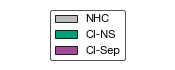

In [4]:
# Define the groups and corresponding colors
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Create a custom legend
legend_elements = [Patch(facecolor=group_palette[group], edgecolor='black', label=group) for group in group_order]

# Create a new figure for the legend
fig, ax = plt.subplots(figsize=(2, 0.5))

# Hide axes
ax.axis('off')

# Add the legend to the figure
ax.legend(handles=legend_elements, loc='center', frameon=True, fontsize=8, edgecolor='black')

# Save the legend as a separate image file
plt.savefig('custom_legend.svg', format='svg')

# Show the legend
plt.show()

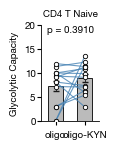

In [39]:
# Load the dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-01_flow_14TSCENITH-NHC-KYNsupp24hr-POOLED_calculated-dependencies_transformed-long.csv'
df = pd.read_csv(file_path)

# Filter for CD4 Tnaive and relevant inhibitors
df_cd4_tnaive = df[(df['CellType'] == 'CD4 Tnaive') & (df['Inhibitor'].isin(['oligo', 'oligo-KYN']))]

# Pivot the data for paired plotting
paired_data = df_cd4_tnaive.pivot(index='SampleID', columns='Inhibitor', values='glyco_cap').dropna()

# Calculate mean and SEM
mean_values = paired_data.mean()
sem_values = paired_data.sem()

# Plot settings
fig, ax = plt.subplots(figsize=(0.75, 1.25))

# Define bar positions with spacing from edges and between bars
bar_positions = [0.35, 0.65]  # Slightly center bars to avoid touching edges

# Create bar plot with SEM error bars
ax.bar(bar_positions, mean_values, yerr=sem_values, color='#BBBBBB', 
       edgecolor='black', capsize=2, width=0.15)  # Narrower width for more spacing

# Overlay individual data points with connecting lines
for j in range(len(paired_data)):
    ax.plot(bar_positions, paired_data.iloc[j], color='#4682B4', linewidth=0.8, alpha=0.8)
    ax.scatter(bar_positions, paired_data.iloc[j], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test and display p-value
stat, p_value = wilcoxon(paired_data['oligo'], paired_data['oligo-KYN'])
ax.text(0.5, 18, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis
ax.set_ylim(0, 20)
ax.set_yticks(np.arange(0, 21, 5))
ax.set_ylabel('Glycolytic Capacity')
ax.tick_params(axis='y', pad=1)  # Reduce padding of y-axis ticks and labels

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['oligo', 'oligo-KYN'])

# Set x-axis limits to create padding
ax.set_xlim(0.2, 0.8)

# Add cell type as title
ax.set_title('CD4 T Naive')

# Display the plot
plt.savefig(24hr-KYN_naive)
plt.show()

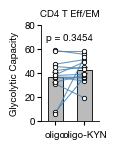

In [43]:
# Load the dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-01_flow_14TSCENITH-NHC-KYNsupp24hr-POOLED_calculated-dependencies_transformed-long.csv'
df = pd.read_csv(file_path)

# Filter for CD4 Teffem and relevant inhibitors
df_cd4_teffem = df[(df['CellType'] == 'CD4 Teffem') & (df['Inhibitor'].isin(['oligo', 'oligo-KYN']))]

# Pivot the data for paired plotting
paired_data = df_cd4_teffem.pivot(index='SampleID', columns='Inhibitor', values='glyco_cap').dropna()

# Calculate mean and SEM
mean_values = paired_data.mean()
sem_values = paired_data.sem()

# Plot settings
fig, ax = plt.subplots(figsize=(0.75, 1.25))

# Define bar positions with spacing from edges and between bars
bar_positions = [0.35, 0.65]  # Slightly center bars to avoid touching edges

# Create bar plot with SEM error bars
ax.bar(bar_positions, mean_values, yerr=sem_values, color='#BBBBBB', 
       edgecolor='black', capsize=2, width=0.15)  # Narrower width for more spacing

# Overlay individual data points with connecting lines
for j in range(len(paired_data)):
    ax.plot(bar_positions, paired_data.iloc[j], color='#4682B4', linewidth=0.8, alpha=0.8)
    ax.scatter(bar_positions, paired_data.iloc[j], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test and display p-value
stat, p_value = wilcoxon(paired_data['oligo'], paired_data['oligo-KYN'])
ax.text(0.5, 65, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis
ax.set_ylim(0, 80)
ax.set_yticks(np.arange(0, 81, 20))
ax.set_ylabel('Glycolytic Capacity')
ax.tick_params(axis='y', pad=1)  # Reduce padding of y-axis ticks and labels

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['oligo', 'oligo-KYN'])

# Set x-axis limits to create padding
ax.set_xlim(0.2, 0.8)

# Add cell type as title
ax.set_title('CD4 T Eff/EM')

# Display and save the plot
plt.savefig('24hr-KYN_GlycoCap_EffEM.svg')
plt.show()

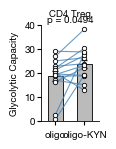

In [48]:
# Load the dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-01_flow_14TSCENITH-NHC-KYNsupp24hr-POOLED_calculated-dependencies_transformed-long.csv'
df = pd.read_csv(file_path)

# Filter for CD4 Treg and relevant inhibitors
df_cd4_treg = df[(df['CellType'] == 'CD4 Treg') & (df['Inhibitor'].isin(['oligo', 'oligo-KYN']))]

# Pivot the data for paired plotting
paired_data = df_cd4_treg.pivot(index='SampleID', columns='Inhibitor', values='glyco_cap').dropna()

# Calculate mean and SEM
mean_values = paired_data.mean()
sem_values = paired_data.sem()

# Plot settings
fig, ax = plt.subplots(figsize=(0.75, 1.25))

# Define bar positions with spacing from edges and between bars
bar_positions = [0.35, 0.65]  # Slightly center bars to avoid touching edges

# Create bar plot with SEM error bars
ax.bar(bar_positions, mean_values, yerr=sem_values, color='#BBBBBB', 
       edgecolor='black', capsize=2, width=0.15)  # Narrower width for more spacing

# Overlay individual data points with connecting lines
for j in range(len(paired_data)):
    ax.plot(bar_positions, paired_data.iloc[j], color='#4682B4', linewidth=0.8, alpha=0.8)
    ax.scatter(bar_positions, paired_data.iloc[j], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test and display p-value
stat, p_value = wilcoxon(paired_data['oligo'], paired_data['oligo-KYN'])
ax.text(0.5, 40, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis
ax.set_ylim(0, 40)
ax.set_yticks(np.arange(0, 41, 10))
ax.set_ylabel('Glycolytic Capacity')
ax.tick_params(axis='y', pad=1)  # Reduce padding of y-axis ticks and labels

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['oligo', 'oligo-KYN'])

# Set x-axis limits to create padding
ax.set_xlim(0.2, 0.8)

# Add cell type as title
ax.set_title('CD4 Treg')

# Display and save the plot
plt.savefig('24hr-KYN_GlycoCap_Treg.svg')
plt.show()

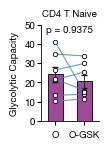

In [53]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-07-16_flow_calculated-dependencies_long.csv'
df = pd.read_csv(file_path)

# Filter for CD4 Tnaive and relevant inhibitors
df_cd4_tnaive = df[(df['CellType'] == 'CD4 Tnaive') & (df['Inhibitor'].isin(['O', 'O-GSK']))]

# Pivot the data for paired plotting
paired_data = df_cd4_tnaive.pivot(index='SampleID', columns='Inhibitor', values='glyco_cap').dropna()

# Calculate mean and SEM
mean_values = paired_data.mean()
sem_values = paired_data.sem()

# Plot settings
fig, ax = plt.subplots(figsize=(0.75, 1.25))

# Define bar positions with spacing from edges and between bars
bar_positions = [0.35, 0.65]  # Slightly center bars to avoid touching edges

# Create bar plot with SEM error bars
ax.bar(bar_positions, mean_values, yerr=sem_values, color='#9F4A96', 
       edgecolor='black', capsize=2, width=0.15)  # Sepsis purple color

# Overlay individual data points with connecting lines
for j in range(len(paired_data)):
    ax.plot(bar_positions, paired_data.iloc[j], color='#4682B4', linewidth=0.8, alpha=0.8)  # Steel blue lines
    ax.scatter(bar_positions, paired_data.iloc[j], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test and display p-value
stat, p_value = wilcoxon(paired_data['O'], paired_data['O-GSK'])
ax.text(0.5, 45, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis
ax.set_ylim(0, 50)
ax.set_yticks(np.arange(0, 51, 10))
ax.set_ylabel('Glycolytic Capacity')
ax.tick_params(axis='y', pad=1)  # Reduce padding of y-axis ticks and labels

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['O', 'O-GSK'])

# Set x-axis limits to create padding
ax.set_xlim(0.2, 0.8)

# Add cell type as title
ax.set_title('CD4 T Naive')

# Display and save the plot
plt.savefig('3hr-KMOi_GlycoCap_Naive.svg')
plt.show()

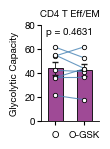

In [59]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-07-16_flow_calculated-dependencies_long.csv'
df = pd.read_csv(file_path)

# Filter for CD4 T Eff/EM and relevant inhibitors
df_cd4_teffem = df[(df['CellType'] == 'CD4 Teffem') & (df['Inhibitor'].isin(['O', 'O-GSK']))]

# Pivot the data for paired plotting
paired_data = df_cd4_teffem.pivot(index='SampleID', columns='Inhibitor', values='glyco_cap').dropna()

# Calculate mean and SEM
mean_values = paired_data.mean()
sem_values = paired_data.sem()

# Plot settings
fig, ax = plt.subplots(figsize=(0.75, 1.25))

# Define bar positions with spacing from edges and between bars
bar_positions = [0.35, 0.65]  # Slightly center bars to avoid touching edges

# Create bar plot with SEM error bars
ax.bar(bar_positions, mean_values, yerr=sem_values, color='#9F4A96', 
       edgecolor='black', capsize=2, width=0.15)  # Sepsis purple color

# Overlay individual data points with connecting lines
for j in range(len(paired_data)):
    ax.plot(bar_positions, paired_data.iloc[j], color='#4682B4', linewidth=0.8, alpha=0.8)  # Steel blue lines
    ax.scatter(bar_positions, paired_data.iloc[j], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test and display p-value
stat, p_value = wilcoxon(paired_data['O'], paired_data['O-GSK'])
ax.text(0.5, 70, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis
ax.set_ylim(0, 80)
ax.set_yticks(np.arange(0, 81, 20))
ax.set_ylabel('Glycolytic Capacity')
ax.tick_params(axis='y', pad=1)  # Reduce padding of y-axis ticks and labels

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['O', 'O-GSK'])

# Set x-axis limits to create padding
ax.set_xlim(0.2, 0.8)

# Add cell type as title
ax.set_title('CD4 T Eff/EM')

# Display and save the plot
plt.savefig('3hr-KMOi_GlycoCap_EffEM.svg')
plt.show()

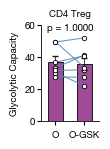

In [63]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-07-16_flow_calculated-dependencies_long.csv'
df = pd.read_csv(file_path)

# Filter for CD4 Treg and relevant inhibitors
df_cd4_treg = df[(df['CellType'] == 'CD4 Treg') & (df['Inhibitor'].isin(['O', 'O-GSK']))]

# Pivot the data for paired plotting
paired_data = df_cd4_treg.pivot(index='SampleID', columns='Inhibitor', values='glyco_cap').dropna()

# Calculate mean and SEM
mean_values = paired_data.mean()
sem_values = paired_data.sem()

# Plot settings
fig, ax = plt.subplots(figsize=(0.75, 1.25))

# Define bar positions with spacing from edges and between bars
bar_positions = [0.35, 0.65]  # Slightly center bars to avoid touching edges

# Create bar plot with SEM error bars
ax.bar(bar_positions, mean_values, yerr=sem_values, color='#9F4A96', 
       edgecolor='black', capsize=2, width=0.15)  # Sepsis purple color

# Overlay individual data points with connecting lines
for j in range(len(paired_data)):
    ax.plot(bar_positions, paired_data.iloc[j], color='#4682B4', linewidth=0.8, alpha=0.8)  # Steel blue lines
    ax.scatter(bar_positions, paired_data.iloc[j], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test and display p-value
stat, p_value = wilcoxon(paired_data['O'], paired_data['O-GSK'])
ax.text(0.5, 45, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis
ax.set_ylim(0, 60)
ax.set_yticks(np.arange(0, 61, 20))
ax.set_ylabel('Glycolytic Capacity')
ax.tick_params(axis='y', pad=1)  # Reduce padding of y-axis ticks and labels

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['O', 'O-GSK'])

# Set x-axis limits to create padding
ax.set_xlim(0.2, 0.8)

# Add cell type as title
ax.set_title('CD4 Treg')

# Display and save the plot
plt.savefig('3hr-KMOi_GlycoCap_Treg.svg')
plt.show()

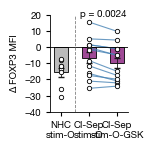

In [223]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_foxp3_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_FOXP3_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 18, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-40, 20)
ax.set_yticks(np.arange(-40, 21, 10))
ax.set_ylabel('Δ FOXP3 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-mfi-foxp3.svg')
plt.show()

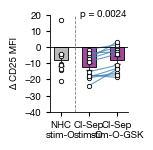

In [224]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_CD25_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_CD25_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 18, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-30, 20)
ax.set_yticks(np.arange(-40, 21, 10))
ax.set_ylabel('Δ CD25 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-mfi-cd25.svg')
plt.show()

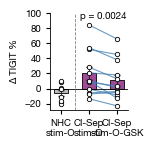

In [225]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_TIGIT_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_TIGIT_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 90, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-28, 100)
ax.set_yticks(np.arange(-20, 101, 20))
ax.set_ylabel('Δ TIGIT %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-TIGIT_pct.svg')
plt.show()

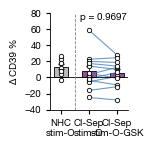

In [226]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_CD39_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_CD39_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 70, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-40, 80)
ax.set_yticks(np.arange(-40, 81, 20))
ax.set_ylabel('Δ CD39 %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-CD39_pct.svg')
plt.show()

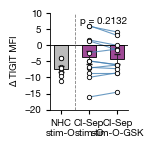

In [227]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_TIGIT_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_TIGIT_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 6, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-20, 10)
ax.set_yticks(np.arange(-20, 11, 5))
ax.set_ylabel('Δ TIGIT MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-TIGIT_mfi.svg')
plt.show()

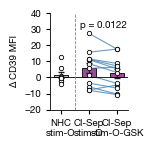

In [228]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_CD39_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_CD39_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 30, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-20, 40)
ax.set_yticks(np.arange(-20, 41, 10))
ax.set_ylabel('Δ CD39 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-CD39_mfi.svg')
plt.show()

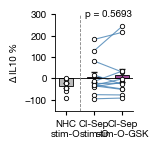

In [229]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IL10_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IL10_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 280, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-150, 300)
ax.set_yticks(np.arange(-100, 301, 100))
ax.set_ylabel('Δ IL10 %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-IL10_pct.svg')
plt.show()

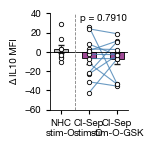

In [230]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Treg-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IL10_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IL10_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 30, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-60, 40)
ax.set_yticks(np.arange(-60, 41, 20))
ax.set_ylabel('Δ IL10 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_treg_delta-IL10_mfi.svg')
plt.show()

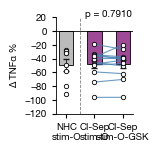

In [231]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_TNFa_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_TNFa_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 18, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-120, 20)
ax.set_yticks(np.arange(-120, 21, 20))
ax.set_ylabel('Δ TNFα %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-TNFa_pct.svg')
plt.show()

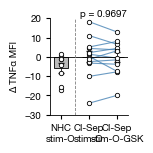

In [232]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_TNFa_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_TNFa_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 20, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-30, 20)
ax.set_yticks(np.arange(-30, 21, 10))
ax.set_ylabel('Δ TNFα MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-TNFa_mfi.svg')
plt.show()

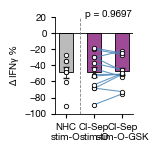

In [233]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IFNg_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IFNg_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 18, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-100, 20)
ax.set_yticks(np.arange(-100, 21, 20))
ax.set_ylabel('Δ IFNγ %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-IFNg_pct.svg')
plt.show()

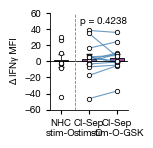

In [234]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IFNg_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IFNg_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 45, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-60, 60)
ax.set_yticks(np.arange(-60, 61, 20))
ax.set_ylabel('Δ IFNγ MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-IFNg_mfi.svg')
plt.show()

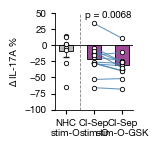

In [235]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IL17A_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IL17A_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 40, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-100, 50)
ax.set_yticks(np.arange(-100, 51, 25))
ax.set_ylabel('Δ IL-17A %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-IL17A_pct.svg')
plt.show()

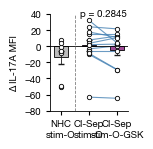

In [236]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IL17A_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IL17A_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 35, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-80, 40)
ax.set_yticks(np.arange(-80, 41, 20))
ax.set_ylabel('Δ IL-17A MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-IL17A_mfi.svg')
plt.show()

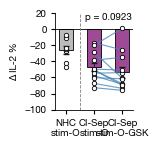

In [237]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IL2_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IL2_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 10, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-100, 20)
ax.set_yticks(np.arange(-100, 21, 20))
ax.set_ylabel('Δ IL-2 %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-IL2_pct.svg')
plt.show()

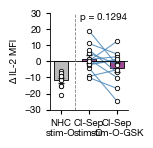

In [238]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_IL2_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_IL2_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 25, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-30, 30)
ax.set_yticks(np.arange(-30, 31, 10))
ax.set_ylabel('Δ IL-2 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-IL2_mfi.svg')
plt.show()

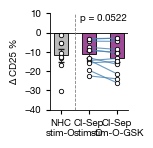

In [239]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_CD25_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_CD25_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 5, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-40, 10)
ax.set_yticks(np.arange(-40, 11, 10))
ax.set_ylabel('Δ CD25 %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-CD25_pct.svg')
plt.show()

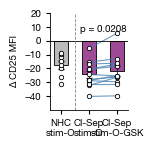

In [240]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_CD25_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_CD25_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 5, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-50, 10)
ax.set_yticks(np.arange(-40, 21, 10))
ax.set_ylabel('Δ CD25 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-CD25_mfi.svg')
plt.show()

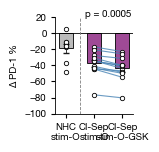

In [241]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_PD1_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_PD1_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 18, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-100, 20)
ax.set_yticks(np.arange(-100, 21, 20))
ax.set_ylabel('Δ PD-1 %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-PD1_pct.svg')
plt.show()

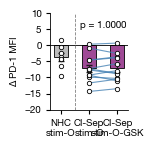

In [242]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_PD1_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_PD1_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 5, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-20, 10)
ax.set_yticks(np.arange(-20, 11, 5))
ax.set_ylabel('Δ PD-1 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-PD1_mfi.svg')
plt.show()

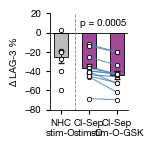

In [243]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_LAG3_pct and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_LAG3_pct') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 5, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-80, 20)
ax.set_yticks(np.arange(-80, 21, 20))
ax.set_ylabel('Δ LAG-3 %')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-LAG3_pct.svg')
plt.show()

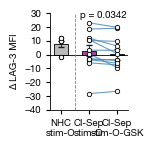

In [244]:
# Load the new dataset
file_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure7/2024-08-09_flow_Tconv-stats-POOLED_long.csv'
df = pd.read_csv(file_path)

# Filter the data to include only delta_LAG3_mfi and the relevant groups and conditions
df_filtered = df[(df['Marker'] == 'delta_LAG3_mfi') & 
                 (df['Group'].isin(['NHC', 'CI-Sep'])) & 
                 (df['Condition'].isin(['stim-O', 'stim-O-GSK']))]

# Calculate means and SEMs for the NHC stim-O, CI-Sep stim-O, and CI-Sep stim-O-GSK groups
means_sems = df_filtered.groupby(['Group', 'Condition'])['Value'].agg(['mean', 'sem']).reset_index()

# Set up the figure
fig, ax = plt.subplots(figsize=(1, 1.25))

# Define bar positions and labels
bar_positions = [0.3, 0.6, 0.9]
bar_labels = ['NHC stim-O', 'CI-Sep stim-O', 'CI-Sep stim-O-GSK']
color_palette = {'NHC': '#BBBBBB', 'CI-Sep': '#9F4A96'}

# Plot bars with SEM error bars
for i, label in enumerate(bar_labels):
    group, condition = label.split()
    mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['mean'].values[0]
    sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['Condition'] == condition)]['sem'].values[0]
    color = color_palette[group]
    ax.bar(bar_positions[i], mean_val, yerr=sem_val, color=color, 
           edgecolor='black', capsize=2, width=0.15)

# Overlay individual data points and connecting lines for CI-Sep paired data
for j, sample_id in enumerate(df_filtered['SampleID'].unique()):
    sample_data = df_filtered[(df_filtered['SampleID'] == sample_id) & 
                              (df_filtered['Group'] == 'CI-Sep') & 
                              (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
    if len(sample_data) == 2:  # Ensure paired data
        ax.plot([0.6, 0.9], sample_data['Value'].values, color='#4682B4', linewidth=0.8, alpha=0.8)
        ax.scatter([0.6, 0.9], sample_data['Value'].values, color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Overlay individual data points for NHC stim-O
nhc_data = df_filtered[(df_filtered['Group'] == 'NHC') & (df_filtered['Condition'] == 'stim-O')]
ax.scatter([0.3] * len(nhc_data), nhc_data['Value'], color='white', edgecolor='black', s=10, zorder=3, linewidth=0.6)

# Perform Wilcoxon test between CI-Sep stim-O and CI-Sep stim-O-GSK
ci_sep_data = df_filtered[(df_filtered['Group'] == 'CI-Sep') & (df_filtered['Condition'].isin(['stim-O', 'stim-O-GSK']))]
paired_data = ci_sep_data.pivot(index='SampleID', columns='Condition', values='Value').dropna()
stat, p_value = wilcoxon(paired_data['stim-O'], paired_data['stim-O-GSK'])
ax.text(0.75, 25, f'p = {p_value:.4f}', ha='center', va='bottom')

# Customize y-axis with specified range
ax.axhline(0, color='black', linewidth=0.6)
ax.set_ylim(-40, 30)
ax.set_yticks(np.arange(-40, 31, 10))
ax.set_ylabel('Δ LAG-3 MFI')

# Add a vertical dashed line between NHC and CI-Sep groups
ax.axvline(x=0.45, color='gray', linestyle='--', linewidth=0.6)

# Customize x-axis
ax.set_xticks(bar_positions)
ax.set_xticklabels(['NHC\nstim-O', 'CI-Sep\nstim-O', 'CI-Sep\nstim-O-GSK'])

# Display the plot
plt.savefig('KMOi_Tconv_delta-LAG3_mfi.svg')
plt.show()

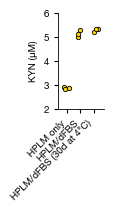

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = "/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/ExtDataFigure3/20240821_kyn_media.csv"
df = pd.read_csv(file_path)

# Extract the group from the sample column
df['Group'] = df['sample'].str.extract(r'([a-zA-Z0-9]+)_')

# Rename groups for clarity
group_rename = {
    'HPLM': 'HPLM only',
    'HPLMdFBS': 'HPLM/dFBS',
    'HPLMdFBS30': 'HPLM/dFBS (30d at 4°C)'
}
df['Group'] = df['Group'].map(group_rename)

# Calculate means and SEMs for each group
mean_values = df.groupby('Group')['kyn_um'].mean()
sem_values = df.groupby('Group')['kyn_um'].sem()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(0.6, 1.25))

# Define the x-axis positions for each group
groups = mean_values.index
x_positions = np.arange(len(groups))

# Plot individual points with jitter
jitter_scale = 0.75  # Adjust jitter scale to spread the dots slightly
for i, group in enumerate(groups):
    group_data = df[df['Group'] == group]['kyn_um']
    jitter = (np.random.rand(len(group_data)) - 0.5) * jitter_scale
    ax.scatter(
        x_positions[i] + jitter, group_data, 
        color='#FFD700', edgecolor='black', s=10, zorder=3, linewidth=0.6
    )

# Customize the axes
ax.set_xticks(x_positions)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylim(2, 6)
ax.set_yticks(np.arange(2, 7, 1))
ax.set_ylabel('KYN (µM)')

# Add extra buffer between ticks and axis
ax.margins(x=0.2)

# Add borders to all four sides
for spine in ax.spines.values():
    spine.set_linewidth(0.6)

# Save the plot
plt.savefig('kyn_media_conc.svg', format='svg')
plt.show()